# Paper ST Sloping - 16 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_16beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,65.861928,67.716291,67.206386,18.973287,2.756737,0.736288,-0.634501,-1.015121,-0.279539,...,-0.038497,0.024202,-0.033980,0.046029,-0.071080,0.009209,-0.027384,-0.007471,-0.007113,NSR
1,e0106,67.175188,66.539171,66.278974,18.879508,2.752145,0.710574,-0.608829,-1.008338,-0.375129,...,-0.045707,0.028543,-0.033995,0.039226,-0.065687,-0.004942,-0.011601,-0.016082,-0.002783,NSR
2,e0106,67.331260,67.526064,67.904703,19.526248,2.883850,0.724048,-0.611290,-1.007119,-0.471325,...,-0.064803,0.051981,-0.056875,0.061396,-0.081542,0.009957,-0.023760,-0.019310,0.008258,NSR
3,e0106,66.507411,69.358972,68.845433,19.399284,2.811633,0.728870,-0.631538,-1.076715,-0.451683,...,-0.042918,0.033450,-0.043966,0.053377,-0.073200,0.002332,-0.021755,-0.003223,-0.021226,NSR
4,e0106,71.500586,69.600473,69.015425,19.518971,2.844739,0.706509,-0.610843,-1.008555,-0.438800,...,-0.047597,0.025825,-0.031552,0.048798,-0.093202,0.026254,-0.038423,-0.005951,-0.003403,NSR


In [5]:
data['label'].value_counts()

NSR    26200
ST-     5498
ST+     2467
Name: label, dtype: int64

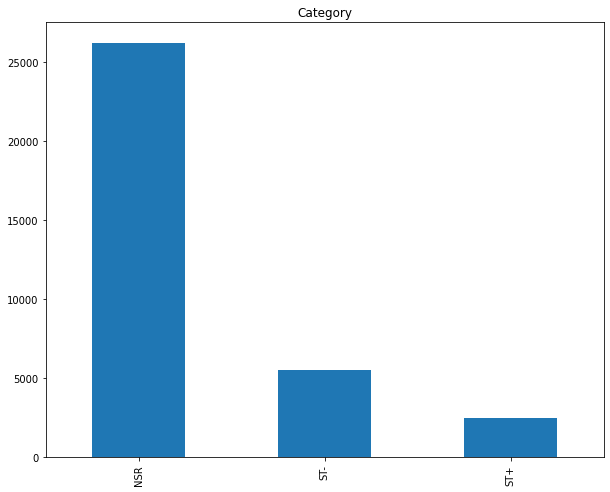

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.219210,0.101301,0.071494,0.053500,0.102907,-0.028753,0.044410,-0.002493,0.004377,...,-0.077538,-0.054871,-0.040977,-0.037365,-0.023672,-0.057237,-0.042960,-0.052143,-0.079161,-0.066310
dw_2,0.219210,1.000000,0.838628,0.486610,0.180151,0.408486,-0.502032,-0.337710,0.001285,0.018225,...,-0.123426,0.167397,0.237288,0.168364,0.049215,0.034692,0.128171,0.009246,-0.115564,-0.075292
dw_3,0.101301,0.838628,1.000000,0.680243,0.272747,0.255846,-0.548064,-0.460442,0.004292,0.010350,...,-0.203574,0.143928,0.272752,0.119350,-0.051559,0.061458,0.046053,-0.019790,-0.131894,-0.046861
dw_4,0.071494,0.486610,0.680243,1.000000,0.880644,-0.012857,-0.262781,-0.246875,0.003327,0.003775,...,-0.154983,0.064231,0.121135,0.050684,-0.040099,0.050791,0.024330,-0.029443,-0.102508,-0.042964
dw_5,0.053500,0.180151,0.272747,0.880644,1.000000,-0.126287,-0.018966,-0.039939,0.000859,0.000096,...,-0.070726,0.009459,0.007874,0.021196,0.000299,0.019165,0.013247,-0.034829,-0.053621,-0.029838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.057237,0.034692,0.061458,0.050791,0.019165,-0.138724,0.094631,0.121316,-0.001690,0.004790,...,-0.134379,-0.207376,-0.072612,0.035689,0.062709,1.000000,0.019376,0.001574,-0.345510,-0.225272
cfr_13,-0.042960,0.128171,0.046053,0.024330,0.013247,0.077703,-0.006064,0.009997,0.003478,-0.000130,...,0.147883,0.041925,-0.211124,-0.268978,-0.011602,0.019376,1.000000,0.223072,0.131959,-0.159064
cfr_14,-0.052143,0.009246,-0.019790,-0.029443,-0.034829,0.004839,0.022487,0.027808,0.003788,-0.003911,...,0.109109,0.222240,0.044405,-0.175685,-0.289441,0.001574,0.223072,1.000000,0.198522,-0.135727
cfr_15,-0.079161,-0.115564,-0.131894,-0.102508,-0.053621,0.045425,0.082850,0.052462,0.001549,-0.008696,...,0.279721,0.160473,-0.089826,-0.144377,-0.074435,-0.345510,0.131959,0.198522,1.000000,0.297959


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_218', 'fft_143', 'fft_211', 'fft_141', 'fft_197', 'fft_253', 'fft_210', 'fft_208', 'fft_183', 'fft_170', 'fft_194', 'fft_237', 'fft_168', 'fft_135', 'fft_185', 'fft_198', 'fft_231', 'fft_148', 'fft_176', 'fft_139', 'fft_212', 'fft_173', 'fft_165', 'fft_222', 'fft_247', 'fft_149', 'mfw_11', 'fft_163', 'fft_220', 'fft_160', 'mfw_7', 'fft_184', 'fft_164', 'fft_233', 'fft_134', 'fft_178', 'fft_214', 'fft_256', 'fft_187', 'fft_132', 'fft_239', 'fft_234', 'fft_161', 'fft_162', 'mfw_9', 'mfw_13', 'fft_189', 'fft_225', 'fft_209', 'fft_192', 'fft_248', 'fft_226', 'fft_206', 'fft_215', 'fft_169', 'fft_130', 'fft_174', 'fft_157', 'fft_182', 'fft_190', 'fft_213', 'fft_250', 'fft_171', 'fft_223', 'fft_242', 'fft_252', 'fft_207', 'fft_181', 'fft_240', 'fft_140', 'mfw_6', 'fft_227', 'fft_167', 'fft_204', 'fft_150', 'fft_241', 'fft_195', 'fft_228', 'fft_238', 'fft_244', 'mfw_8', 'fft_188', 'fft_138', 'fft_144', 'fft_232', 'fft_217', 'fft_172', 'fft_205', 'fft_221', 'fft_249', 'fft_146', 'fft_202

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 78


### Visualization best features

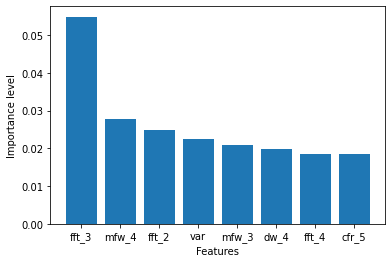

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,65.861928,67.716291,67.206386,18.973287,2.756737,0.736288,-0.634501,-1.015121,-0.279539,0.905306,...,0.020720,0.039231,-0.038497,0.024202,-0.033980,0.046029,-0.071080,0.009209,-0.027384,-0.007471
1,67.175188,66.539171,66.278974,18.879508,2.752145,0.710574,-0.608829,-1.008338,-0.375129,-0.354970,...,0.009445,0.040896,-0.045707,0.028543,-0.033995,0.039226,-0.065687,-0.004942,-0.011601,-0.016082
2,67.331260,67.526064,67.904703,19.526248,2.883850,0.724048,-0.611290,-1.007119,-0.471325,1.782405,...,0.011313,0.048344,-0.064803,0.051981,-0.056875,0.061396,-0.081542,0.009957,-0.023760,-0.019310
3,66.507411,69.358972,68.845433,19.399284,2.811633,0.728870,-0.631538,-1.076715,-0.451683,-3.475203,...,0.013055,0.040612,-0.042918,0.033450,-0.043966,0.053377,-0.073200,0.002332,-0.021755,-0.003223
4,71.500586,69.600473,69.015425,19.518971,2.844739,0.706509,-0.610843,-1.008555,-0.438800,-1.080058,...,0.004456,0.042616,-0.047597,0.025825,-0.031552,0.048798,-0.093202,0.026254,-0.038423,-0.005951


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, seed in enumerate(seeds):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=seed)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 6.5809338092803955 s
Tot: Accuracy 0.9221425435387092 Precision 0.9228700786662044 Recall 0.9221425435387092 Specificity 0.7844230333293134 F1 0.917899729184698
NSR: Accuracy 0.9224352407434508 Precision 0.9199285075960679 Recall 0.9843182252820807 Specificity 0.7206982543640897 F1 0.9510347376201036
ST+: Accuracy 0.9833162593297234 Precision 0.9282511210762332 Recall 0.8346774193548387 Specificity 0.9949502919362474 F1 0.8789808917197452
ST-: Accuracy 0.9833162593297234 precision 0.9343434343434344 Recall 0.6678700361010831 Specificity 0.9909170305676855 F1 0.7789473684210527
#---------------------#
#---------------------#
2 of 1000 - 6.610913276672363 s
Tot: Accuracy 0.9218498463339675 Precision 0.9216339429435036 Recall 0.9218498463339675 Specificity 0.776123817574692 F1 0.9178083904823491
NSR: Accuracy 0.92228889214108 Precision 0.9226137772268461 Recall 0.9822775263951734 Specificity 0.7141922825376062 F1 0.9515112775089032
ST+: Accuracy 0.98038

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.922143,0.922870,0.922143,0.784423,0.917900,0.922435,0.919929,0.984318,0.720698,0.951035,0.983316,0.928251,0.834677,0.994950,0.878981,0.983316,0.934343,0.667870,0.990917,0.778947
1,0.921850,0.921634,0.921850,0.776124,0.917808,0.922289,0.922614,0.982278,0.714192,0.951511,0.980389,0.917840,0.797959,0.994482,0.853712,0.980389,0.918421,0.671800,0.989299,0.775987
2,0.919069,0.919562,0.919069,0.777896,0.914763,0.919069,0.916905,0.983139,0.711896,0.948867,0.981706,0.940909,0.807018,0.995886,0.868835,0.981706,0.922208,0.667575,0.989184,0.774499
3,0.916728,0.917668,0.916728,0.773823,0.911907,0.916874,0.914582,0.982719,0.705846,0.947427,0.982731,0.914414,0.835391,0.994013,0.873118,0.982731,0.933165,0.649693,0.990692,0.766046
4,0.928875,0.928817,0.928875,0.795538,0.925493,0.928875,0.928381,0.984136,0.738622,0.955446,0.985365,0.947115,0.834746,0.996541,0.887387,0.985365,0.922886,0.696060,0.989249,0.793583
5,0.920094,0.921005,0.920094,0.785480,0.915824,0.920386,0.917161,0.983998,0.719927,0.949405,0.981853,0.930886,0.824092,0.994929,0.874239,0.981853,0.934161,0.669635,0.990718,0.780083
6,0.916874,0.917884,0.916874,0.766525,0.911867,0.917020,0.914093,0.984139,0.697500,0.947824,0.981267,0.926009,0.812992,0.994783,0.865828,0.981267,0.932271,0.642857,0.991117,0.760976
7,0.919362,0.919612,0.919362,0.785193,0.915259,0.919362,0.918195,0.981549,0.720859,0.948816,0.983316,0.929385,0.830957,0.995112,0.877419,0.983316,0.921875,0.673398,0.988584,0.778285
8,0.923460,0.924811,0.923460,0.771625,0.918886,0.923752,0.919781,0.987507,0.706452,0.952442,0.982731,0.934307,0.808421,0.995753,0.866817,0.982731,0.945333,0.659535,0.992879,0.776986
9,0.916142,0.916707,0.916142,0.768457,0.911434,0.916435,0.915348,0.981877,0.700817,0.947446,0.979950,0.903448,0.805328,0.993381,0.851571,0.979950,0.929032,0.652765,0.990401,0.766773


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_16beats_1000x_random_split.csv')

######## Total ########
Accuracy 0.9205875896385189
Precision 0.9211026025950542
Recall 0.9205875896385189
Specificity 0.7803627307257209
F1 0.9163221671770125
######## NSR ########
Accuracy 0.9207434509000438
Precision 0.9193115966949381
Recall 0.9829323532841199
Specificity 0.7161501330573122
F1 0.9500530392004316
######## ST+ ########
Accuracy 0.9821254207522317
Precision 0.920707457888931
Recall 0.8239195215870406
Specificity 0.9944658994367164
F1 0.8694989090462143
######## ST- ########
Accuracy 0.9821254207522317
Precision 0.929641139419479
Recall 0.6667156611208238
Specificity 0.9903342878702112
F1 0.7764277493406214
